# Modeling Building<br/>*Stacking and VotingClassifiers*

## Goals
1. Describe Ensembles
2. Describe the Stacking Algorithm
3. Custom Code a Stacking Classifier
4. Use Stacking Classifier and Analyze Results
5. Use VotingClassifier and Analyze Results
6. Tune Base Learners and Analysze Results
7. Simplify and present interpretable decision tree

## Ensemble Description
An *ensemble* makes use of multiple models to improve predictions.  Each model in the ensemble is called a *base learner* (or base estimator).  The predictions from the base learners are fed into another model, the *meta learner*, to create the final prediction.

An ensemble of base learners is analogous to a group of experts.  Each person in the group can vote on a recommendation, the votes can be tallied up, and the "winner" is the best recommendation.  In this example, each expert is a *base learner* and "tallying up the votes" is the *meta learner* used to combine the recommendations.

For an ensemble to work well:
* each expert should be better at predicting than random chance
* the experts should not always agree with each other

Some of Scikit Learn's estimators are ensembles that consist of multiple base learners which are trained internally, the results combined, and a prediction is made.  See: [Scikit Learn Ensembles](https://scikit-learn.org/stable/modules/ensemble.html)

There are many types of ensembles.  The type discussed here is called a Stack.

In this notebook, a custom Stack estimator will be coded from scratch and used on the Titanic data set.

## Prepare Data for Modeling
Same as in previous notebooks.

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

import titanic_helper_code as tt

In [2]:
# Version Information
import sys
print('python:     ', sys.version)
print('numpy:      ', np.__version__)
print('pandas:     ', pd.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn:    ', sns.__version__)
print('sklearn:    ', sk.__version__)
!lsb_release -d

python:      3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy:       1.16.4
pandas:      0.24.2
matplotlib:  3.1.0
seaborn:     0.9.0
sklearn:     0.21.2
Description:	Ubuntu 18.04.2 LTS


In [3]:
# Scikit Learn imports
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer

# conda install py-xgboost
from xgboost import XGBClassifier

In [4]:
# explictly enable and import new iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Performance of Individual Models
Initially, the base learners will use default values for all hyperparameters.

As per first notebook, unless otherwise noted, these notebooks use:  
* Model Selection: 10-Repeated 2-Fold Cross Validation 
  * or 5-Repeated 2-Fold CV for nested operations
* Model Evaluation: 10-Repeated 10-Fold Cross Validation  

In [5]:
# get the X predictor matrix and the y target vector
X, y = tt.get_Xy_v6()

# instantiate a few estimators using Scikit Learn defaults
lr  = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
xgb = XGBClassifier(objective='binary:logistic')
svm = SVC(gamma='auto', probability=True)
nn  = MLPClassifier(max_iter=2000, random_state=101)

# apply the ColumnTransform logic used in previous notebooks
cols, ct = tt.get_ct_v5()
lr_pipe = Pipeline([('ct', ct), ('lr', lr)])
knn_pipe = Pipeline([('ct', ct), ('knn', knn)])
# xgb seems to work better without the data preprocessing
svm_pipe = Pipeline([('ct', ct), ('svm', svm)])
nn_pipe = Pipeline([('ct', ct), ('nn', nn)])

base_learners = [lr_pipe, knn_pipe, xgb, svm_pipe, nn_pipe]

In [6]:
# Cross Validation Generators used in this Notebook
cv_select = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, 
                                    random_state=108)
cv_select_quick = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, 
                                          random_state=108)
cv_predict = StratifiedKFold(n_splits=10, random_state=1001)

In [7]:
# Evaluate the Accuracy of each base learner
for base_learner in base_learners:
    if hasattr(base_learner, 'steps'):
        name = base_learner.steps[1][0].upper()
    else:
        name = base_learner.__class__.__name__

    scores  = cross_val_score(base_learner,  X, y, scoring='accuracy', 
                              cv=cv_select)
    print(f'{name:13} Score: {scores.mean():.3f} +/- {scores.std():.3f}')

LR            Score: 0.830 +/- 0.013
KNN           Score: 0.806 +/- 0.015
XGBClassifier Score: 0.823 +/- 0.013
SVM           Score: 0.831 +/- 0.013
NN            Score: 0.816 +/- 0.016


### **cross_val_score** and **cross_val_predict**  

**cross_val_score**  
Uses cross validation to predict on each of K test folds, scores that prediction, and returns each of the K scores.

cross_val_score will call the estimator's predict or predict_proba method, depending upon the scoring object used.

**cross_val_predict**  
Uses cross validation to predict on each of K test folds and returns len(X_train) predictions.

These predictions can be scored in any way, including the same way they are scored with cross_val_score.

### Use **cross_val_predict** to get scores
Using **cross_val_predict** to get the same scores as **cross_val_score** is helpful in understanding how these functions work.

In [8]:
# Part 1: Accuracy -- cross_val_score using predict
acc_scores = cross_val_score(lr_pipe, X, y, 
                             scoring='accuracy', cv=cv_predict)

acc_scores2 = []
predictions = cross_val_predict(lr_pipe, X, y, 
                                cv=cv_predict, method='predict')

for train_index, test_index in cv_predict.split(X, y):
    fold_score = accuracy_score(y.iloc[test_index], 
                                predictions[test_index])
    acc_scores2.append(fold_score)

# verify scores are the same
print((acc_scores == acc_scores2).all())

True


In [9]:
# Part 2: Log Loss -- cross_val_score using predict_proba
logloss_scores = cross_val_score(lr_pipe, X, y, 
                                 scoring='neg_log_loss', cv=cv_predict)

logloss_scores2 = []
predictions = cross_val_predict(lr_pipe, X, y,
                                cv=cv_predict, method='predict_proba')

for train_index, test_index in cv_predict.split(X, y):
    fold_score = -log_loss(y.iloc[test_index], 
                           predictions[test_index])
    logloss_scores2.append(fold_score)

# verify results are the same
print((logloss_scores == logloss_scores2).all())

True


## Stacking

**Algorithm**  
1. fit on train
   * create training meta-features using base learners with cross_val_predict
   * fit meta-learner on training meta-features
   * fit base learners (for next step)
2. predict on test
   * create test meta-features using fitted base learners
   * create predictions using fitted meta-learner on test meta-features

### Stacking Algorithm: cross_val_predict  
In general, the model building process should not have a step which both fits and predicts on the same data.  In step 1 above, had the training meta-features been created by fitting the base learners on the training data and then using those base learners to predict on that same training data, this would have been overfitting.

Instead the meta level features in step 1 above should use "cross validated predictions".  Here is a quote from Scikit Learn on [cross_val_predict](https://scikit-learn.org/stable/modules/cross_validation.html#obtaining-predictions-by-cross-validation)
> The function cross_val_predict is appropriate for:  
* Visualization of predictions obtained from different models.  
* Model blending: When predictions of one supervised estimator are used to train another estimator in ensemble methods. 

An good alternative description of the Stacking algorithm, which also describes the use of cross validated predictions for meta level features, can be found at:  
[Super Learner Algorithm](https://h2o-release.s3.amazonaws.com/h2o/rel-ueno/2/docs-website/h2o-docs/data-science/stacked-ensembles.html#super-learner-algorithm)

### Why Build a Custom Stacking Estimator
There are several good libraries available for stacking such as [mlxtend](http://rasbt.github.io/mlxtend/) and [mlens](https://mlens.readthedocs.io/en/0.1.x/).

As of May 2019, mlxtend did not work with ColumnTransformer (introduced in September of 2018).  ColumnTransformer, or  [sklearn-pandas](https://github.com/scikit-learn-contrib/sklearn-pandas) is necessary to preprocess input features using a clean work flow.  All previous notebooks in this series used ColumnTransformer.

Creating a custom classifier allows for continued use of ColumnTransformer, and shows how easy the basics of building a custom classifier are.

A good approach to software development is to first create a simple working example, and then abstract that logic into an object or function.  A key to making this process simple, is to take care in choosing variable and method names which accurately convey to any developer, what each step is doing.

### Stacking Example

Above algorithm in six steps:
1. create train/test split
2. creating training meta-features
3. fit meta-learner to training meta-features
4. fit base learners
5. create test meta-features
6. predict and evaluate fitted meta-learner on test meta-features

#### 1. Train/Test Split
Key Points:  
* Train/Test split used for illustration.  Cross Validation is better for this data set.

In [10]:
# Start with train/test split, later use cross validation
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.333, random_state=1001)

#### 2. Create Training Meta-Features
Key points:
* use cross_val_predict on training data to avoid overfitting
* for classification, use predict_proba to provide more information to the meta-learner

In [11]:
# predict_proba outputs [probability NotSurvived, probability Survived]
# select the 2nd column only
p1_train = cross_val_predict(lr_pipe, X_train, y_train, cv=cv_predict, 
                             method='predict_proba')[:, 1]
p2_train = cross_val_predict(svm_pipe, X_train, y_train, cv=cv_predict, 
                             method='predict_proba')[:, 1]

# combine features into meta-features matrix
meta_train = np.column_stack((p1_train, p2_train))

#### 3. Fit Meta Learner

In [12]:
meta_learner = SVC(gamma='auto')
meta_learner.fit(meta_train, y_train);

#### 4. Fit Base Learners

In [13]:
# fit base learners on all of train
lr_pipe.fit(X_train, y_train)
svm_pipe.fit(X_train, y_train);

#### 5. Create Test Meta Features

In [14]:
# predict probability of survived
p1_test= lr_pipe.predict_proba(X_test)[:, 1]
p2_test = svm_pipe.predict_proba(X_test)[:, 1]

# combine features into meta-features matrix
meta_test = np.column_stack((p1_test, p2_test))

#### 6. Predict and Evaluate

In [15]:
meta_pred = meta_learner.predict(meta_test)
score = accuracy_score(y_test, meta_pred)
np.round(score, 3)

0.832

#### Above Score May Have Strong Bias and Variance
The above score was computed from a single train/test split.  The Titanic data set is small, so both the train and test sets are small.  A small train set my cause a large score bias.  A small test split may cause a large score variance.  Cross Validation should be used instead.

## Create Custom Stacking Classifier

The custom Stacking classifier created below will:
* work with ColumnTransformer
* work with cross_val_score
* not work with GridSearchCV
* not use parallelization to speed up operation
* not report usage errors

See: [Rolling your own estimator](https://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator)

In [16]:
from sklearn.base import BaseEstimator, ClassifierMixin
class StackedClassifier(BaseEstimator, ClassifierMixin):
    '''Minimal Stacking Classifier
    
       Uses predict_proba for level 1 meta features.
    '''

    def __init__(self, base_learners, meta_learner, cv):
        self.base_learners = base_learners
        self.meta_learner = meta_learner
        self.cv = cv

    def fit(self, X, y):      
        
        # Create Training Features
        train_cols = []
        for base_learner in self.base_learners:
            tmp = cross_val_predict(base_learner, X, y, cv=self.cv,
                                    method='predict_proba')[:, 1]
            train_cols.append(tmp)
        X_meta_train = np.column_stack(train_cols)
        
        # fit meta learner on train
        self.meta_learner.fit(X_meta_train, y)
        
        # fit the base learners on the entire training data
        for base_learner in self.base_learners:
            base_learner.fit(X, y)

        # Return the classifier
        return self

    def predict(self, X):
        
        # Create Test Features
        test_cols = []
        for base_learner in self.base_learners:
            tmp = base_learner.predict_proba(X)[:, 1]
            test_cols.append(tmp)
        X_meta_test = np.column_stack(test_cols)
        
        predictions = self.meta_learner.predict(X_meta_test)

        return predictions

### Experiment with Custom Stacked Classifier
These experiments use SVC as the meta learner.

Per the above, the individual models scored:  
LR            Score: 0.830 +/- 0.013  
KNN           Score: 0.806 +/- 0.015  
XGBClassifier Score: 0.823 +/- 0.013  
SVM           Score: 0.831 +/- 0.013  
NN            Score: 0.816 +/- 0.016  

Ideally we would like to see a score better than the single best score above.

In [17]:
# Prepare the individual base learners

# Instantiate Estimators
lr  = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
xgb = XGBClassifier(objective='binary:logistic')
svm = SVC(gamma='auto', probability=True)
nn  = MLPClassifier(max_iter=2000, random_state=101)

# Get ColumnTransform Preprocessing Object
cols, ct = tt.get_ct_v5()

# Prepend Preprocessing to create Pipeline
lr_pipe = Pipeline([('ct', ct), ('lr', lr)])
knn_pipe = Pipeline([('ct', ct), ('knn', knn)])
# xgb seems to work better without the data preprocessing
svm_pipe = Pipeline([('ct', ct), ('svm', svm)])
nn_pipe = Pipeline([('ct', ct), ('nn', nn)])

#### Base Learners: LogitReg, KNN, SVC

In [18]:
# LR, KNN with SVM meta learner
base_learners = [lr_pipe, knn_pipe]
meta_learner = SVC(gamma='auto')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.809 max:0.850
CV Mean Score: 0.826 +/- 0.013


#### Base Learners: LogitReg, SVC

In [19]:
# LR, SVM with SVM meta learner
base_learners = [lr_pipe, svm_pipe]
meta_learner = SVC(gamma='auto')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.812 max:0.854
CV Mean Score: 0.832 +/- 0.014


#### Base Learners: LogitReg, XGB, SVC

In [20]:
# LR, SVM, XGB with SVM meta learner
base_learners = [lr_pipe, svm_pipe, xgb]
meta_learner = SVC(gamma='auto')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.809 max:0.854
CV Mean Score: 0.832 +/- 0.013


#### Base Learners: LogitReg, XGB, SVC, KNN

In [21]:
# LR, SVM, KNN, XGB with SVM meta learner
base_learners = [lr_pipe, svm_pipe, knn_pipe, xgb]
meta_learner = SVC(gamma='auto')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.809 max:0.852
CV Mean Score: 0.832 +/- 0.012


In [50]:
#### Base Learners: LogitReg, SVC, KNN, XGB, NeuralNetwork

In [22]:
# LR, SVM, KNN, XGB, NN with SVM meta learner
base_learners = [lr_pipe, svm_pipe, knn_pipe, xgb, nn_pipe]
meta_learner = SVC(gamma='auto')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.809 max:0.854
CV Mean Score: 0.830 +/- 0.014


### Analysis of Stacking Results
More experiments were tried than are presented above, but the above results are illustrative of what happened.

There was little or no improvement.  The Titanic data set is small and simple.

Above, both the base learners and the meta learner did not have their hyperparameters tuned.  This will be tried next.

## Optimize Base Learners for use with Stacked Classifier

The base learners are being used to generate probabilities as meta-features for the meta learner.  For the meta learner to work well, these probabilities should be [calibrated](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html).

Unfortunately, just as there is too little data for a hold-out set for model evaluation, there is too little data for another hold-out set for probability calibration.  Calibration cannot be done here.

For LogisticRegression, log loss probabilities are already calibrated due to the definition of its objective function.

For SupportVectorClassifier, probabilities do not exist at all, due to the definition of its objective function.  To return probabilities, a special technique invented by John Platt is used.  See [Scores and Probabilities](https://scikit-learn.org/stable/modules/svm.html#scores-probabilities).

A possible alternative to calibrating the probabilities is to tune the base learner's hyperparameters such that the log loss score is optimized.  Log loss appropriately measures the error between the predicted probability and the target value.  This was tried and did not work well.  These results are not shown here.

Ideally all the base learners and the meta-learner, would be optimized together.  An ensemble predicts well if its base learners are diverse, and this diversity is not captured when optimizing the base learners one at a time.  Unfortunately this is too computationally intensive and it is not well supported by the above simple Stacking classifier.

Given the simplicity and small size of the Titanic data set, optimizing the base learners and the meta learner are unlikely to be helpful.  Nevertheless, the results are shown below as an example of how to approach this problem.

Another type of ensemble, directly supported by Scikit Learn, is the VotingClassifier.  This is simpler than a Stacking classifier and will be tried later in this notebook.

Next, each base learner will be optimized by accuracy, a few stacking experiments will be tried, and the best base learners will be used with a metal learner which is itself optimized for accuracy.

### Optimize Base Learners for Accuracy
GridSearchCV will be used here.

As with previous notebooks, get_Xy encodes the Titanic data and get_ct provides the ColumnTransformer which transforms the encoded data.

In [23]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

##### **Logistic Regression**  
To be thorough, the saga solver will be used which allows for penalty='elasticnet'.

In [24]:
lr  = LogisticRegression(solver='saga', penalty='elasticnet',
                         max_iter=5000)
lr_pipe_best = Pipeline([('ct', ct), ('lr', lr)])

params = {'lr__C': np.logspace(-2, 2, 20),
          'lr__l1_ratio': np.linspace(0, 1, 3)}
grid = GridSearchCV(estimator=lr_pipe_best, param_grid=params, 
                    scoring='accuracy', cv=cv_select)

grid.fit(X, y);

In [25]:
df_lr = tt.print_grid(grid, pandas=True)

Best: 0.832 +/- 0.014
lr__C: 3.359818286283781
lr__l1_ratio: 0.0


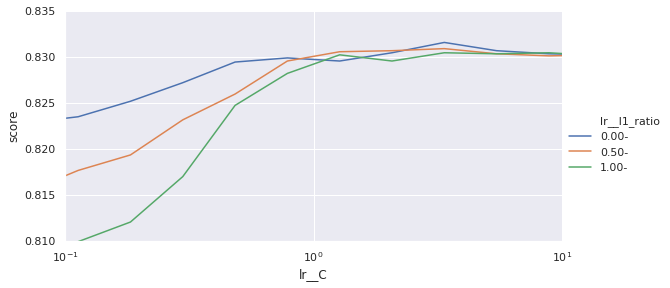

In [26]:
# workaround for Seaborn bug with hue=numeric-variable
# convert ratio to string and append a non-numeric character
df = df_lr.copy()
df['lr__l1_ratio'] = df_lr['lr__l1_ratio'].apply(lambda x: f'{x:.2f}-')

g = sns.relplot(x='lr__C', y='score', hue = 'lr__l1_ratio',
                height=4, aspect=2.0,
                data=df, ci=None, kind='line');

ax = g.axes[0, 0]
ax.set_xscale('log')
ax.set_xlim(.1, 10)
ax.set_ylim(.810, .835);

A local maxima is seen with l1_ratio=0, so the hyperparameter grid values are good.

An l1_ratio of 0 implies use of an L2 penalty only, which is the default for LogisticRegression.  Also, for this small dataset, liblinear converges faster than saga.  In the following, liblinear will be used.

In [27]:
# verify liblinear produces same result with default penalty
best_c = grid.best_params_['lr__C']
lr  = LogisticRegression(solver='liblinear', C=best_c)
lr_pipe_best = Pipeline([('ct', ct), ('lr', lr)])

scores= cross_val_score(lr_pipe_best, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.812 max:0.859
CV Mean Score: 0.832 +/- 0.014


##### **Support Vector Machine** 

In [28]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

svm = SVC(gamma='auto', probability=True)
svm_pipe_best = Pipeline([('ct', ct), ('svm', svm)])

params = {'svm__C': np.logspace(2, 4, 3),
          'svm__gamma': np.logspace(-4, -1, 4)}

grid = GridSearchCV(estimator=svm_pipe_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

grid.fit(X, y);

In [29]:
df_svm = tt.print_grid(grid, pandas=True)

Best: 0.833 +/- 0.013
svm__C: 1000.0
svm__gamma: 0.001


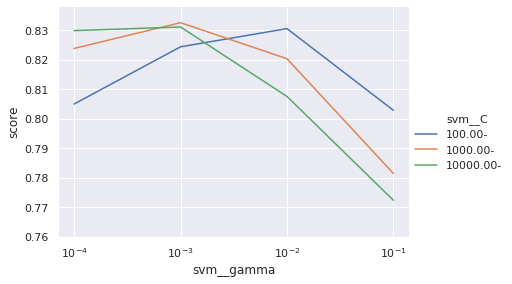

In [34]:
# workaround for Seaborn hue bug
df = df_svm.copy()
df['svm__C'] = df['svm__C'].apply(lambda x: f'{x:.2f}-')

g = sns.relplot("svm__gamma", "score", hue="svm__C", data=df,
                kind="line", height=4.0, aspect=1.5)
ax = g.axes[0,0]
ax.set_xscale('log')
ax.set_ylim(0.76, 0.838);

From the above, its possible that the local maxima for the green curve lies between .0001 and .001 and is higher than the local maxima for the orange curve.

Add a point between .0001 and .001 and rerun GridSearchCV.

In [35]:
params = {'svm__C': np.logspace(2, 4, 3),
          'svm__gamma': [.0001, .0005, .001, .01, .1]}

grid = GridSearchCV(estimator=svm_pipe_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

grid.fit(X, y);

In [36]:
df_svm = tt.print_grid(grid, pandas=True)

Best: 0.834 +/- 0.014
svm__C: 10000.0
svm__gamma: 0.0005


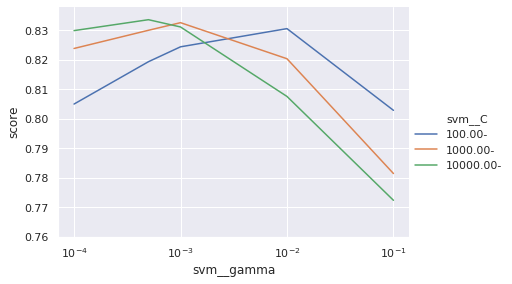

In [37]:
# workaround for Seaborn hue bug
df = df_svm.copy()
df['svm__C'] = df['svm__C'].apply(lambda x: f'{x:.2f}-')

g = sns.relplot("svm__gamma", "score", hue="svm__C", data=df,
                kind="line", height=4.0, aspect=1.5)
ax = g.axes[0,0]
ax.set_xscale('log')
ax.set_ylim(0.76, 0.838);

A higher score was found.  Although the difference is insignificant, it is worthwhile to understand how to adjust the hyperparameter grid values to ensure that a local maxima is reached along each dimension.

When the slope along one dimension is plotted as nearly flat, and it is near the optimum value, then it may be that the plotted points fall on either side of the optimal point.  Adding a point in the flat section can find the local optima.

##### **KNN**  

In [38]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

knn = KNeighborsClassifier()
knn_pipe_best = Pipeline([('ct', ct), ('knn', knn)])

params = {'knn__n_neighbors': [2, 3, 5, 8, 13, 21, 34, 55, 89],
          'knn__weights': ['uniform', 'distance'],
          'knn__p':[1, 2]}

grid = GridSearchCV(estimator=knn_pipe_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

# find the best hyperparameters and associated score
grid.fit(X, y);

In [39]:
df_knn = tt.print_grid(grid, pandas=True)

Best: 0.824 +/- 0.016
knn__n_neighbors: 13
knn__p: 1
knn__weights: uniform


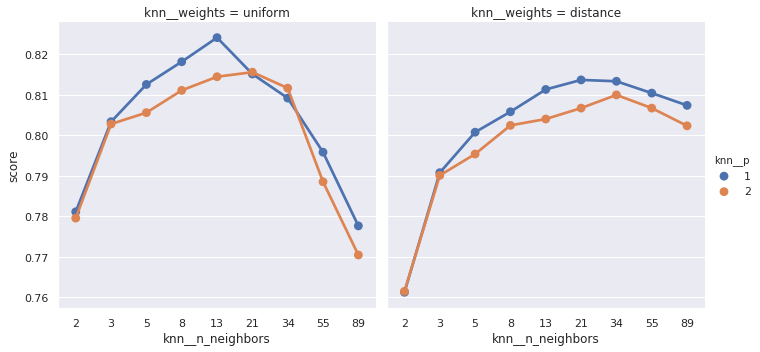

In [40]:
# sns.relplot, with the workaround, works well here too
g = sns.catplot("knn__n_neighbors", "score", "knn__p", 
                col="knn__weights", data=df_knn, kind="point")

In the above, weights='uniform' is clearly doing better than weights='distance'.

It's probably splitting hairs, but a better local maxima could be found by fixing weights='uniform' (to save computation time) and trying more values of n between about 10 and 15.

In [42]:
params = {'knn__n_neighbors': [10, 11, 12, 13, 14, 15],
          'knn__weights': ['uniform'],
          'knn__p':[1, 2]}

grid = GridSearchCV(estimator=knn_pipe_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

grid.fit(X, y);

In [43]:
df_knn = tt.print_grid(grid, pandas=True)

Best: 0.824 +/- 0.015
knn__n_neighbors: 12
knn__p: 1
knn__weights: uniform


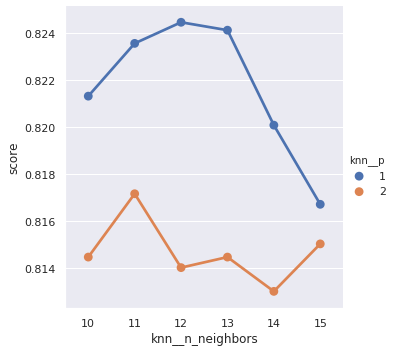

In [44]:
g = sns.catplot("knn__n_neighbors", "score", "knn__p", 
                data=df_knn, kind="point")

The difference between K=12 and K=13 is likely due to pure chance, but as 12 is better, it might as well be used.

##### **XGB** 

In [52]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

xgb_best = XGBClassifier(objective='binary:logistic', random_state=48)

params = {'n_estimators': [100], 
          'learning_rate': [0.01, .02, .03, .04,
                            .05, .06, .07, .08],
          'max_depth': [5, 6, 7, 8, 9, 10, 11],
          'colsample_bytree': [1.0, 0.6, 0.5, 0.4]}
grid = GridSearchCV(estimator=xgb_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

grid.fit(X, y);

In [53]:
df_xgb = tt.print_grid(grid, pandas=True)

Best: 0.833 +/- 0.014
colsample_bytree: 0.5
learning_rate: 0.03
max_depth: 11
n_estimators: 100


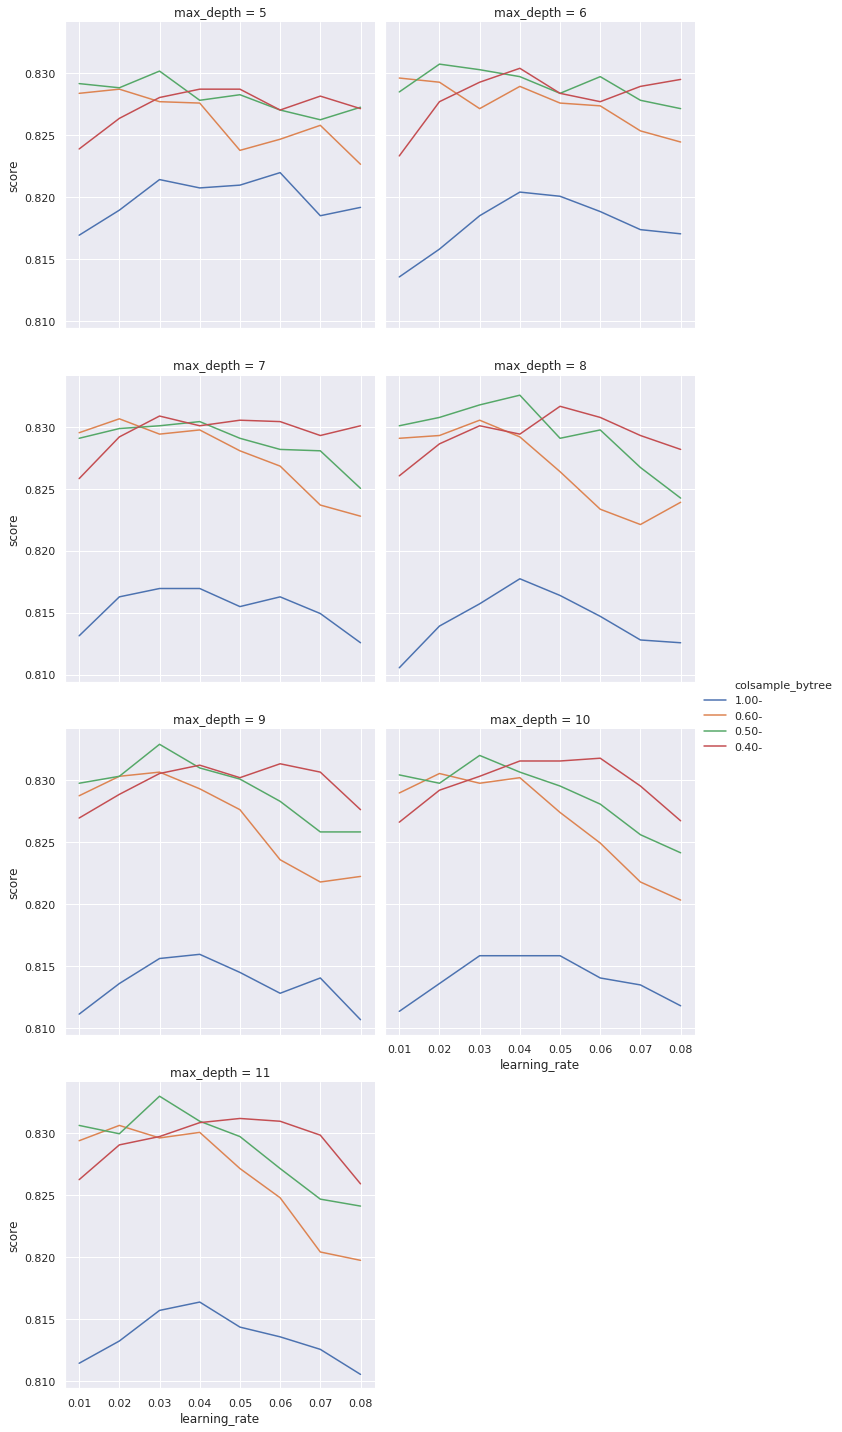

In [54]:
# workaround for Seaborn hue bug
df = df_xgb.copy()
df['colsample_bytree'] = \
    df['colsample_bytree'].apply(lambda x: f'{x:.2f}-')

g = sns.relplot("learning_rate", "score", "colsample_bytree", 
                col="max_depth", col_wrap=2, 
                data=df, kind="line", ci=None)

##### Examining the XGB Facet Plots
Above can be seen there there are numerous combinations of values which produce results above .830.  Any of these, such as the one found by GridSearchCV, should be fine to use.

From the above, it is likely that a local maxima exists near the values found by GridSearchCV.  Adjusting the parameters is unlikely to make much difference.

#### **Neural Network** 
There are an infinite number of possibilities. Keras and other packages are better.  Here, try a few with the Scikit Learn's Neural Network.

In [55]:
alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1]

In [56]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

nn = MLPClassifier(max_iter=2000, random_state=909)
nn_pipe_best = Pipeline([('ct', ct), ('nn', nn)])

params = {'nn__hidden_layer_sizes':[(50,),(100,),(200,)],
          'nn__alpha':alpha_values}       
grid = GridSearchCV(estimator=nn_pipe_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

# find the best hyperparameters and associated score
grid.fit(X, y);

In [57]:
df_nn = tt.print_grid(grid, pandas=True)

Best: 0.832 +/- 0.016
nn__alpha: 0.5
nn__hidden_layer_sizes: (50,)


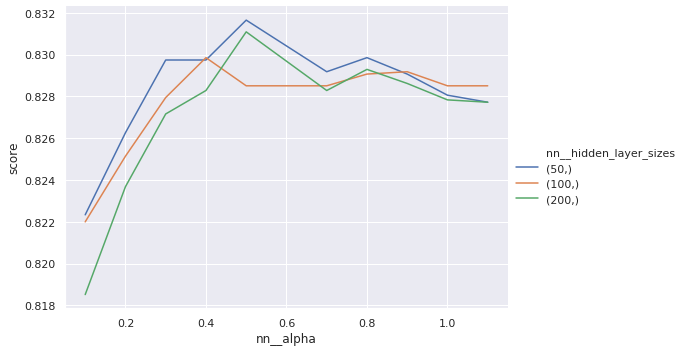

In [58]:
g = sns.relplot("nn__alpha", "score", "nn__hidden_layer_sizes",
                data=df_nn, kind="line", height=5, aspect=1.5, 
                ci=None)

With neural networks, or xgb or any classifier built on many individual models, it is useful to change the random_state to see how different the plot is.  Although not shown here, the above plot was similar to those which used a different random_state.

## Stacking with Optimized Base Learners

### Instantiate each of the Optimized Base Learners

In [59]:
idx = df_lr['score'].idxmax()
c = df_lr['lr__C'][idx]
lr_best = LogisticRegression(penalty='l2', solver='liblinear', C=c)
lr_pipe_best = Pipeline([('ct', ct), ('lr', lr_best)])

In [60]:
idx = df_svm['score'].idxmax()
gamma = df_svm['svm__gamma'][idx]
c = df_svm['svm__C'][idx]
svm_best = SVC(gamma=gamma, C=c, probability=True)
svm_pipe_best = Pipeline([('ct', ct), ('svm', svm_best)])

In [61]:
idx = df_knn['score'].idxmax()
n_neighbors = df_knn['knn__n_neighbors'][idx]
p = df_knn['knn__p'][idx]
weights = df_knn['knn__weights'][idx]
knn_best = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
knn_pipe_best = Pipeline([('ct', ct), ('knn', knn_best)])

In [62]:
idx = df_xgb['score'].idxmax()
colsample_bytree = df_xgb['colsample_bytree'][idx]
learning_rate = df_xgb['learning_rate'][idx]
max_depth = df_xgb['max_depth'][idx]
n_estimators = df_xgb['n_estimators'][idx]
xgb_best = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate,
                         colsample_bytree=colsample_bytree, max_depth=max_depth,
                         random_state=48)

In [63]:
idx = df_nn['score'].idxmax()
hidden_layer_sizes = df_nn['nn__hidden_layer_sizes'][idx]
alpha = df_nn['nn__alpha'][idx]

nn_best = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha,
                       max_iter=2000, random_state=909)
nn_pipe_best = Pipeline([('ct', ct), ('nn', nn_best)])

#### Verify Accuracy of Optimized Base Learners

In [64]:
# Evaluate the Accuracy of each base learner
base_learners = [lr_pipe_best, knn_pipe_best, xgb_best, 
                 svm_pipe_best, nn_pipe_best]

for base_learner in base_learners:
    if hasattr(base_learner, 'steps'):
        name = base_learner.steps[1][0].upper()
    else:
        name = base_learner.__class__.__name__
        
    scores  = cross_val_score(base_learner,  X, y, scoring='accuracy', cv=cv_select)
    print(f'{name:13} Score: {scores.mean():.3f} +/- {scores.std():.3f}')

LR            Score: 0.832 +/- 0.014
KNN           Score: 0.824 +/- 0.015
XGBClassifier Score: 0.833 +/- 0.014
SVM           Score: 0.834 +/- 0.014
NN            Score: 0.832 +/- 0.016


Default Instance Scores    
LR            Score: 0.830 +/- 0.013  
KNN           Score: 0.806 +/- 0.015  
XGBClassifier Score: 0.823 +/- 0.013  
SVM           Score: 0.831 +/- 0.013  
NN            Score: 0.816 +/- 0.016  

#### Base Learners: LogitReg, SVC, XGB

In [65]:
base_learners = [lr_pipe_best, svm_pipe_best, xgb_best]
meta_learner = SVC(gamma='auto')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.813 max:0.863
CV Mean Score: 0.834 +/- 0.014


#### Base Learners: LogitReg, SVC, KNN, XGB

In [66]:
base_learners = [lr_pipe_best, svm_pipe_best, knn_pipe_best, xgb_best]
meta_learner = SVC(gamma='auto')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.813 max:0.863
CV Mean Score: 0.834 +/- 0.014


#### Base Learners: LogitReg, SVC, KNN, XGB, NeuralNetwork

In [67]:
base_learners = [lr_pipe_best, svm_pipe_best, knn_pipe_best, 
                 xgb_best, nn_pipe_best]
meta_learner = SVC(gamma='auto')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.813 max:0.863
CV Mean Score: 0.834 +/- 0.014


The above shows a slight but insignificant improvement.

### Tune Meta Learner
The meta learner will be tuned for use with the optimized LogitReg, SVC and XGB base learners.

To keep the custom StackingClassifier simple, it was not coded to work with GridSearchCV.  The hyperparameter optimization has to be coded by hand, however Scikit Learn provides a nice helper function to make this easy.

In [81]:
from sklearn.model_selection import ParameterGrid

# try ParameterGrid
params = {'gamma': np.logspace(-3, -2, 2),
          'C': np.logspace(-2, 0, 3)}
for param in ParameterGrid(params):
    print(param)

{'C': 0.01, 'gamma': 0.001}
{'C': 0.01, 'gamma': 0.01}
{'C': 0.1, 'gamma': 0.001}
{'C': 0.1, 'gamma': 0.01}
{'C': 1.0, 'gamma': 0.001}
{'C': 1.0, 'gamma': 0.01}


In [74]:
base_learners = [lr_pipe_best, svm_pipe_best, xgb_best]

results = []
for param in ParameterGrid(params):
    meta_learner = SVC(**param)
    sc = StackedClassifier(base_learners, meta_learner, cv_predict)
    scores = cross_val_score(sc, X, y, cv=cv_select_quick)
    g = param['gamma']
    c = param['C']
    score = scores.mean()
    sd = scores.std()
    results.append({'gamma': g, 'C': c, 'score': score, 'sd': sd})
    print(f'gamma: {g:7.3f} C: {c:8.2f} score {score:6.4f} +/- {sd:6.4f}')       

results = pd.DataFrame(results)

gamma:   0.001 C:     0.01 score 0.6162 +/- 0.0004
gamma:   0.010 C:     0.01 score 0.6162 +/- 0.0004
gamma:   0.100 C:     0.01 score 0.6162 +/- 0.0004
gamma:   1.000 C:     0.01 score 0.8229 +/- 0.0105
gamma:   0.001 C:     0.10 score 0.6162 +/- 0.0004
gamma:   0.010 C:     0.10 score 0.6162 +/- 0.0004
gamma:   0.100 C:     0.10 score 0.8334 +/- 0.0102
gamma:   1.000 C:     0.10 score 0.8319 +/- 0.0101
gamma:   0.001 C:     1.00 score 0.6162 +/- 0.0004
gamma:   0.010 C:     1.00 score 0.8334 +/- 0.0092
gamma:   0.100 C:     1.00 score 0.8326 +/- 0.0113
gamma:   1.000 C:     1.00 score 0.8332 +/- 0.0112
gamma:   0.001 C:    10.00 score 0.8332 +/- 0.0093
gamma:   0.010 C:    10.00 score 0.8326 +/- 0.0103
gamma:   0.100 C:    10.00 score 0.8312 +/- 0.0105
gamma:   1.000 C:    10.00 score 0.8308 +/- 0.0124
gamma:   0.001 C:   100.00 score 0.8317 +/- 0.0099
gamma:   0.010 C:   100.00 score 0.8326 +/- 0.0104
gamma:   0.100 C:   100.00 score 0.8301 +/- 0.0111
gamma:   1.000 C:   100.00 scor

In [80]:
results.sort_values('score',ascending=False).head()

C  gamma     score        sd
6    0.1  0.100  0.833449  0.010224
9    1.0  0.010  0.833449  0.009183
11   1.0  1.000  0.833226  0.011245
12  10.0  0.001  0.833224  0.009257
10   1.0  0.100  0.832553  0.011328

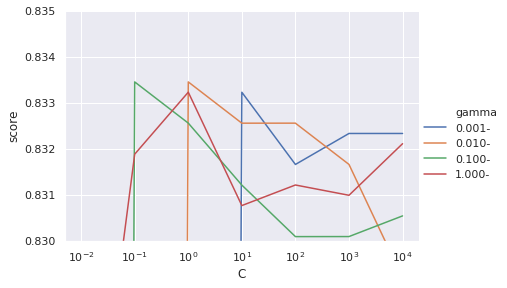

In [79]:
# workaround for Seaborn hue bug
df = results.copy()
df['gamma'] = df['gamma'].apply(lambda x: f'{x:.3f}-')

g = sns.relplot("C", "score", hue="gamma", data=df,
                kind="line", height=4.0, aspect=1.5)
ax = g.axes[0,0]
ax.set_xscale('log')
ax.set_ylim(0.830, 0.835);

From the above plot, it appears the local maxima has been reached.

The result of Stacking, using individually tuned base learners and an individually tuned meta learner, did not result in a significantly better model.

## Voting Classifier
The [voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) is similar to the stacked classifier, except that the meta learner makes use the sum of the probabilities (voting=soft) or the sum of the class label predictions (voting=hard) for each of its base learners.

From the documentation:
> voting : str, {‘hard’, ‘soft’} (default=’hard’)
If ‘hard’, uses predicted class labels for majority rule voting. Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.

A "well-calibrated classifier" is one in which the probabilities have been tuned to be more accurate.  This requires a hold-out set for the probability tuning and the Titanic data set is too small for an additional hold-out set.

### Experiment with some VotingClassifier Ensembles

#### LogitReg, SVC

In [82]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best)], 
                      voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.809 max:0.852
CV Mean Score: 0.833 +/- 0.013


In [83]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best)], 
                      voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.812 max:0.859
CV Mean Score: 0.834 +/- 0.015


#### LogitReg, SVC, XGB

In [84]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best)], voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.816 max:0.863
CV Mean Score: 0.835 +/- 0.014


In [85]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best)], voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.818 max:0.854
CV Mean Score: 0.834 +/- 0.012


#### LogitReg, SVC, XGB, KNN

In [86]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best), ('knn', knn_pipe_best)],
                       voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.818 max:0.857
CV Mean Score: 0.836 +/- 0.012


In [88]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best)], voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.818 max:0.854
CV Mean Score: 0.834 +/- 0.012


#### LogitReg, SVC, XGB, NeuralNetwork

In [101]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best), ('nn', nn_pipe_best)], 
                       voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.818 max:0.861
CV Mean Score: 0.834 +/- 0.014


In [102]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best), ('nn', nn_pipe_best)], 
                       voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.816 max:0.861
CV Mean Score: 0.836 +/- 0.014


#### LogitReg, SVC, XGB, NeuralNetwork

In [103]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best), ('nn', nn_pipe_best)], 
                      voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.818 max:0.863
CV Mean Score: 0.834 +/- 0.014


In [104]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best), ('nn', nn_pipe_best)], 
                      voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.816 max:0.861
CV Mean Score: 0.836 +/- 0.014


#### LogitReg, SVC, KNN, XGB, NeuralNetwork

In [106]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('knn', knn_pipe_best), ('xgb', xgb_best),
                       ('nn', nn_pipe_best)], voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.818 max:0.859
CV Mean Score: 0.834 +/- 0.014


In [107]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('knn', knn_pipe_best), ('xgb', xgb_best),
                       ('nn', nn_pipe_best)], voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.813 max:0.858
CV Mean Score: 0.835 +/- 0.013


### Initial Voting Classifier Results Analysis
More experiments were tried than are presented above, but the above results are illustrative of what happened.

The result of using a VotingClassifier, using individually tuned base learners, did not result in a significantly better model.

## Custom Forest of Trees
The following is an example of creating a forest of decision trees using the Sckkit Learn API.

A forest of trees should be created using a Scikit Learn estimator which creates many trees or XGBoost.

This example is only mean to show that it is possible to produce a reasonable classifier out of decision trees with just two ideas:
1. Each tree should be diverse
2. Each tree should be better than average

In [8]:
# copied from titanic_help_code.py
def get_ct_bycolumn(cols):
    """Column Transform for Features

    """

    ii = WrappedIterativeImputer('Age')

    # Pipelines
    ii_pipe = Pipeline([('ii', ii)])

    # Columns to act on
    ii_cols = ['Pclass', 'Sex', 'Age', 'Title_Master',
                  'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other']

    if 'Age' in cols:
        # cols.remove is an inplace operation
        # which operates on a reference
        cols = cols.copy()
        cols.remove('Age')
        transformers = [('ii_tr', ii_pipe, ii_cols),
                        ('as_is', 'passthrough', cols)]
        return_cols = ['Age'] + cols
    else:
        transformers = [('as_is', 'passthrough', cols)]
        return_cols = cols

    ct = ColumnTransformer(transformers=transformers)

    return return_cols, ct

In [8]:
X.columns.to_list()

['Pclass',
 'Sex',
 'Age',
 'Fare',
 'family_size',
 'is_cabin_notnull',
 'Port_C',
 'Port_Q',
 'Port_S',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Other']

When XGB was tuned above, colsample_bytree was optimized at 0.50.  This suggests that half of the features should be used at any given time.

Tree diversity is ensured by using all possible combinations of the 

In [9]:
# get all possible combinations of the 14 fields taken 7 at a time
import itertools
subsets = list(itertools.combinations(X.columns, r=7))
len(subsets)

3432

### Multi procesing
cross_val_score can be used with n_jobs=-1 however for a single decision tree, this results in too small a unit-of-work.  Each fold is parallelized.

This can be seen as the CPU meter does not show all hardware cores being used.  This is in part because of the setup and tear down time of the internal job pool for cross_val_score.

As 20 folds are being evaluated, submitting this to Python's multiprocessing pool.map will result in a unit-of-work that is 20 times larger.  As the pool is set up once and torn down once, this overhead is avoided.

This yields a higher throughput.

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

In [11]:
from collections import namedtuple
Score = namedtuple('Score', 
                   ['acc', 'acc_std', 'logloss', 'logloss_std','vars'])
def eval_tree(s):
    cols_returned, ct = tt.get_ct_bycolumn(list(s))    
    dtree = DecisionTreeClassifier(random_state=707)
    pipe = Pipeline([('ct', ct), ('dtree', dtree)])
    scores = cross_validate(pipe, X, y, cv=cv_select,
                            scoring=('accuracy', 'neg_log_loss'))
    return Score(scores['test_accuracy'].mean(),
                 scores['test_accuracy'].std(),
                 scores['test_neg_log_loss'].mean(),
                 scores['test_neg_log_loss'].std(),
                 s)

In [18]:
import multiprocessing as mp
import tqdm
import time

pool = mp.Pool(4)

start = time.time()
scores = list(tqdm.tqdm(
    pool.imap_unordered(eval_tree, subsets, chunksize=1), 
              total=len(subsets)))
stop = time.time()

100%|██████████| 3432/3432 [15:22<00:00,  3.72it/s]


In [19]:
print(f'Time: {stop-start:7.1f}')
pool.close()
pool.join()

Time:   922.2


In [20]:
# save it to avoid redoing the above long running operation
# scores_df = pd.DataFrame(scores)
# scores_df.to_csv('data/tree_scores.csv', index=False)

In [21]:
# read it back (if we didn't just save it)
tree_scores = pd.read_csv('data/tree_scores.csv')
tree_scores.head()

acc   acc_std   logloss  logloss_std  \
0  0.768577  0.014719 -7.847498     0.505880   
1  0.769812  0.014353 -7.808523     0.516839   
2  0.764876  0.015845 -7.975553     0.546027   
3  0.771499  0.018042 -7.750423     0.656320   
4  0.769475  0.015908 -7.820157     0.566681   

                                                vars  
0  ('Pclass', 'Sex', 'Age', 'Fare', 'family_size'...  
1  ('Pclass', 'Sex', 'Age', 'Fare', 'family_size'...  
2  ('Pclass', 'Sex', 'Age', 'Fare', 'family_size'...  
3  ('Pclass', 'Sex', 'Age', 'Fare', 'family_size'...  
4  ('Pclass', 'Sex', 'Age', 'Fare', 'family_size'...

### Create Forest

In [22]:
best = scores_df.nlargest(n=len(subsets)//2, columns=['acc'])
best.shape

(1716, 5)

In [24]:
# instantiate each tree and place them in a list
best_trees = []
for i, s in enumerate(best['vars']):
    cols_returned, ct = tt.get_ct_bycolumn(list(s))    
    dtree = DecisionTreeClassifier(random_state=707)
    pipe = Pipeline([('ct', ct), ('dtree', dtree)])
    best_trees.append((f'{i}', pipe))

In [25]:
vc = VotingClassifier(best_trees, voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.803 max:0.861
CV Mean Score: 0.833 +/- 0.015


In [26]:
vc = VotingClassifier(best_trees, voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.809 max:0.863
CV Mean Score: 0.832 +/- 0.014


A good ensemble classifier was created for this data set simply by:
1. creating a default DecisionTree for each combination of half of the variables
2. creating a collection of trees from the top 50% best trees created in step 1, as per their cross validated score 

In practice, XGBoost or similar should be used for a forest of trees.

# Summary

Several ensemble methods were tried:
* Stacking via a custom coded Stacking estimator
* VoteingClassifier
* Forest of Trees via a custom coded collection of decision trees

In addition the base learners, and in the case of Stacking, the meta learner, was individually optimized.

Despite all of this, the results on the Titanic data set did not improve.

In the next section a single small DecistionTree will be used to interpret the Titanic data.  This provides insight into why the more complext methods were not able to show any improvement.

For those who received more than 85% accurary for the Titanic data set, it is likely they custom coded their classifier to match the answer.  That is, they incorportated the test data into the training process, which leads to highly inflated estimates of model performance.